In [1]:
# Cell 0: Imports & paths
from pathlib import Path
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys

# Find project root
def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# Project imports
from common.config import DEVICE, BASE_DIR, WAVES_DIR, SECTIONS_DIR
from models.autoencoder import ConvAutoencoder  # or ConvAutoencoderNormEnd if that's your class
from models.autoencoder import DatasetAutoencoder
from models.pixel_nn import PixelDataset
from models.pixel_nn import PixelClassifier  # ← adjust to your actual module if different
from models.autoencoder.utils import split_dataset

# ---- Configure checkpoints (EDIT THESE) ----
AE_CKPT = Path(r"C:\Users\jaime\S-RAY\deep-learning-wall-tomography\artifacts\autoencoder\checkpoints\ConvAENormEnd_resample150_lat16_do20_bn_2025-08-17_08-41-43.pt")
PIXEL_CKPT = Path(r"C:\Users\jaime\S-RAY\deep-learning-wall-tomography\artifacts\pixel_nn\checkpoints\PixelMLP_32bs_1e-04lr_2025-08-17_11-26-54.pt")

# ---- Held-out data ----
HELD_OUT_WAVES = Path(r"C:\Users\jaime\S-RAY\deep-learning-wall-tomography\data_held_out\waveforms")
HELD_OUT_SECTS = Path(r"C:\Users\jaime\S-RAY\deep-learning-wall-tomography\data_held_out\sections")

# ---- Evaluation output dir ----
ts = time.strftime('%Y-%m-%d_%H-%M-%S')
EVAL_DIR = Path(BASE_DIR) / "results" / "pixel_nn" / f"eval_{ts}"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

print("Eval dir:", EVAL_DIR)

# ---- Autoencoder information ----
REDUCTION = "resample"
N = 150
BATCH_SIZE = 32
SEED = 42
TRAIN_FRAC = 0.8

# ---- Pixel nn information ----
N_X, N_Y = 30, 20
BINARIZED = True


config.py: DEVICE is set as cuda
Eval dir: C:\Users\jaime\S-RAY\deep-learning-wall-tomography\results\pixel_nn\eval_2025-08-19_07-52-59


In [2]:
ae_ds_eval = DatasetAutoencoder(
    path=HELD_OUT_WAVES,
    reduction=REDUCTION,
    n=N,
    save=False,
    force_reload=True
)

In [3]:
# Cell 1: Load pretrained Autoencoder

ae_ds_eval = DatasetAutoencoder(
    path=HELD_OUT_WAVES,
    reduction=REDUCTION,
    n=N,
    save=False,
    force_reload=True
)

autoencoder = ConvAutoencoder.load(
    path=AE_CKPT,
    dataset=ae_ds_eval,
    device=DEVICE
).to(DEVICE)
autoencoder.eval()
print("Loaded AE:", AE_CKPT)


Loaded AE: C:\Users\jaime\S-RAY\deep-learning-wall-tomography\artifacts\autoencoder\checkpoints\ConvAENormEnd_resample150_lat16_do20_bn_2025-08-17_08-41-43.pt


In [4]:
# Cell 2: Held-out PixelDataset
heldout_ds = PixelDataset(
    autoencoder=autoencoder,
    nX=N_X, nY=N_Y,
    # geometry bounds — keep in sync with training config
    Xmin=0.0, Xmax=0.6,
    Ymin=0.0, Ymax=0.4,
    path_waveforms=HELD_OUT_WAVES,
    path_sections=HELD_OUT_SECTS,
    binarized=BINARIZED,
    save=False,                 # caches encoded waves & D matrix features
    force_reload=True, 
    reduction=REDUCTION,
    reduction_n=N
)
print("Held-out sections:", heldout_ds.num_sections)
print("Labels shape:", heldout_ds.labels.shape)   # (num_sections, nY, nX)

Encoded waveforms with shape torch.Size([1188, 16]) (num_waveforms, encoding_dims)
Loaded 18 section labels from C:\Users\jaime\S-RAY\deep-learning-wall-tomography\data_held_out\sections: [WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00300.jpg'), WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00301.jpg'), WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00302.jpg'), WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00303.jpg'), WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00304.jpg'), WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00305.jpg'), WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00306.jpg'), WindowsPath('C:/Users/jaime/S-RAY/deep-learning-wall-tomography/data_held_out/sections/00307.jpg'), WindowsPath

In [ ]:
# Cell 3: Load PixelClassifier from ckpt (uses provided dataset)
model = PixelClassifier.load(
    path=PIXEL_CKPT,
    dataset=heldout_ds,
    device=DEVICE
).to(DEVICE)
model.eval()

OrderedDict([('model.0.weight', tensor([[-4.6367e-01,  4.2049e-01, -4.3481e-01,  ..., -2.3474e-02,
         -4.2222e-02,  6.7845e-02],
        [-2.0924e+00, -1.4203e+00, -1.9891e+00,  ..., -3.7747e-03,
         -5.4597e-02, -1.9147e-03],
        [-1.1259e-01, -6.5377e-02, -1.0237e-01,  ..., -5.4124e-02,
          3.9814e-02,  2.1411e-02],
        ...,
        [-1.3193e+00,  3.4790e+00, -1.2599e+00,  ..., -2.7456e-02,
         -4.2026e-03, -1.3404e-02],
        [-5.5911e-01,  1.0812e+00, -5.2178e-01,  ..., -3.7568e-03,
          1.3793e-02,  1.8718e-02],
        [ 1.8861e+00,  3.3487e-01,  1.8209e+00,  ...,  8.4530e-03,
         -3.2376e-02,  2.0360e-02]], device='cuda:0')), ('model.0.bias', tensor([-3.4875e-02,  2.8897e-03, -1.1742e-01, -4.9838e-02, -8.7899e-02,
        -5.3678e-02,  4.4243e-02,  7.3109e-03,  5.2913e-02, -2.7553e-02,
        -2.3723e-02,  1.3400e-02, -1.5043e-02, -1.4441e-01, -3.1084e-03,
         4.6182e-02,  1.9791e-03, -2.5000e-02,  1.4718e-02,  1.6333e-02,
        

C:\Users\jaime\S-RAY\deep-learning-wall-tomography\models\pixel_nn\dataset_pixel.py:202: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[p, y, x])


PixelClassifier(
  (model): Sequential(
    (0): Linear(in_features=1390, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

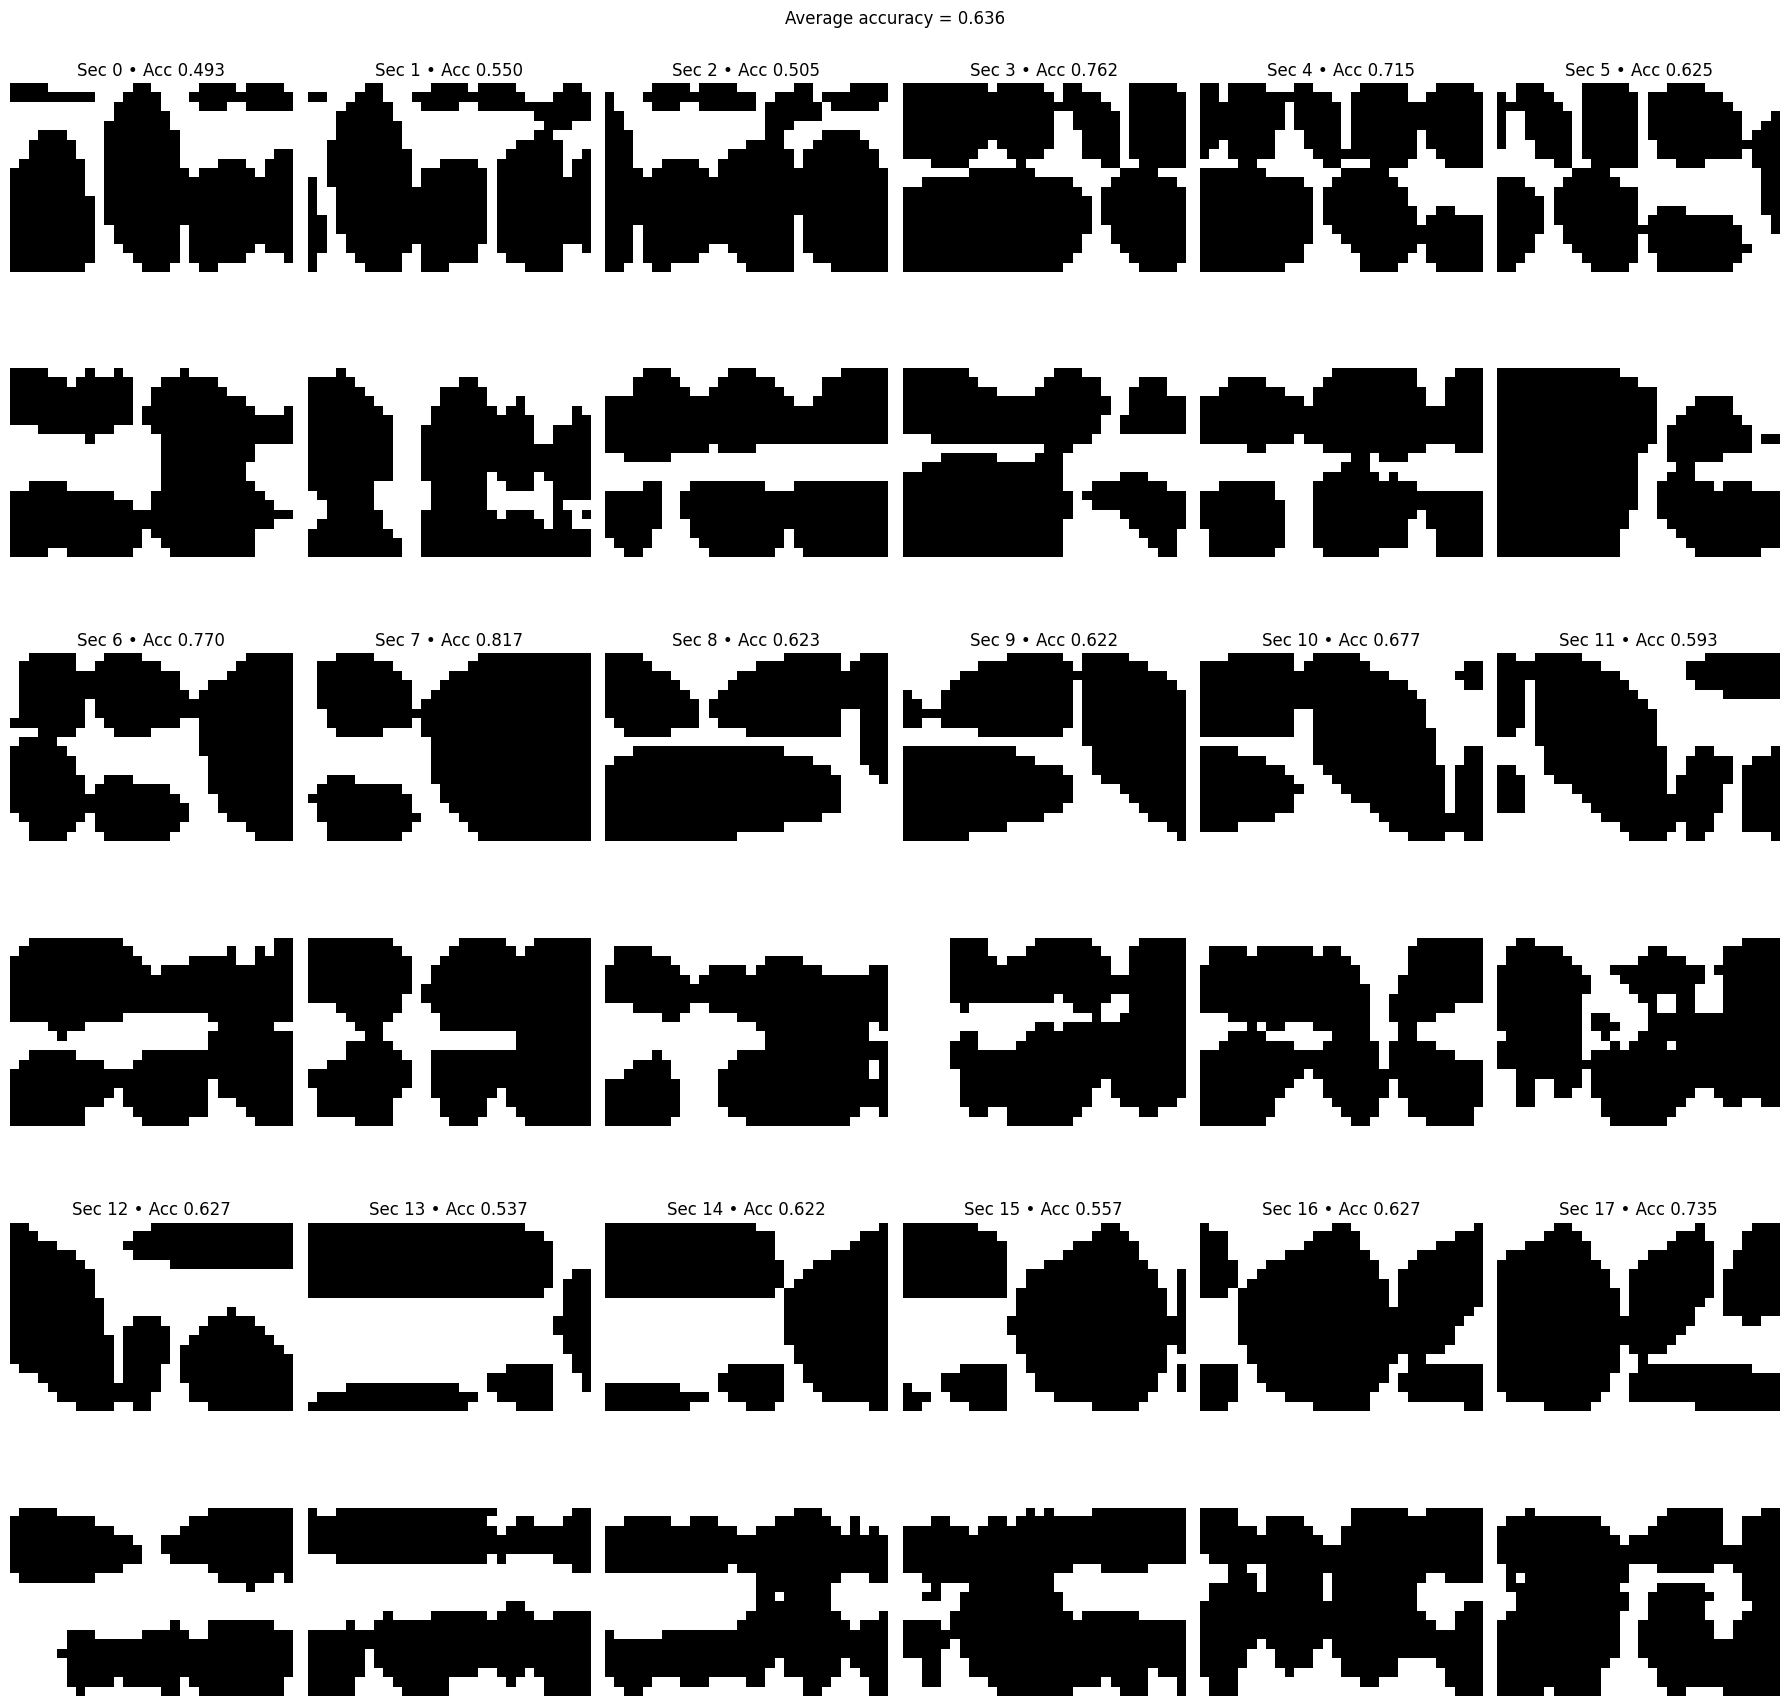

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader

def plot_sections_acc_grid(sect_ids, thr=0.5, max_columns=8):
    # normalize to list of ints
    if not hasattr(sect_ids, "__iter__"):
        sect_ids = [int(sect_ids)]
    sect_ids = [int(s) for s in sect_ids]

    nX, nY = heldout_ds.nX, heldout_ds.nY
    DIM = nX * nY
    is_binary = getattr(model, "binary", True)

    n = len(sect_ids)
    cols = max(1, min(max_columns, n))
    row_blocks = int(np.ceil(n / cols))  # each block has 2 rows: GT + Pred

    fig_w = 3.0 * cols
    fig_h = 3.0 * (2 * row_blocks)
    fig, axes = plt.subplots(2 * row_blocks, cols, squeeze=False, figsize=(fig_w, fig_h))

    accs = []
    for j, sec in enumerate(sect_ids):
        rb = j // cols
        c  = j % cols

        idxs = range(sec * DIM, (sec + 1) * DIM)
        feats, labs = next(iter(DataLoader(Subset(heldout_ds, list(idxs)), batch_size=DIM, shuffle=False)))

        with torch.no_grad():
            preds = model(feats.to(DEVICE)).detach().cpu().view(nY, nX).numpy()

        gt = labs.view(nY, nX).numpy()
        gt_bin   = gt.astype(np.float32) if is_binary else (gt >= 0.5).astype(np.float32)
        pred_bin = (preds >= thr).astype(np.float32)

        acc = float((pred_bin == gt_bin).mean())
        accs.append(acc)

        ax_gt  = axes[2*rb,   c]
        ax_pred= axes[2*rb+1, c]

        ax_gt.imshow(gt_bin, cmap='gray');   ax_gt.axis('off');   ax_gt.set_title(f"Sec {sec} • Acc {acc:.3f}")
        ax_pred.imshow(pred_bin, cmap='gray'); ax_pred.axis('off')

        if c == 0:
            ax_gt.set_ylabel("GT", fontweight="bold")
            ax_pred.set_ylabel(f"Pred (≥{thr:.2f})", fontweight="bold")

    fig.suptitle(f"Average accuracy = {np.mean(accs):.3f}", y=0.98)
    fig.tight_layout()
    plt.show()

# Examples:
plot_sections_acc_grid(range(0, 18), thr=0.5, max_columns=6)
